***Nama : Laily Khoirunnisa'***

*Membuat Model Prediksi Time Series 'Gold Price' (Harga Emas dari Tahun ke Tahun)*

`Submission 2-Time Series Kelas Dicoding: Pengembangan Machine Learning`

<h1> <strong> 1. Import library yang diperlukan</strong></h1>

In [2]:
import numpy as np
import pandas as pd
import zipfile,os
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from sklearn.preprocessing import StandardScaler

<h1> <strong> 2. Mengambil dataset dari Kaggle</strong></h1>

In [3]:
!pip install -q kaggle
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

Saving kaggle.json to kaggle.json
kaggle.json
  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 22.9MB/s]


In [3]:
!ls

kaggle.json  learn-time-series-forecasting-from-gold-price.zip	sample_data


<h1> <strong> 3. Ekstraksi dataset Gold Price</strong></h1>

In [4]:
local_zip = 'learn-time-series-forecasting-from-gold-price.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

<h1> <strong> 4. Preprocessing dataset Gold Price</strong></h1>

<h6> <strong> a. Mengubah dataset ke bentuk dataframe</strong></h6>

In [5]:
df = pd.read_csv('/tmp/gold_price_data.csv')
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [6]:
df.tail()

,Date,Value
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70
10786,2020-03-13,1562.80


<h6> <strong> b. Mengubah tipe data 'Date' dari String menjadi Datetime</strong></h6>

In [7]:
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')

<h6> <strong> c. Cek nilai Null pada data</strong></h6>

In [8]:
df.isnull().sum()

Date     0
Value    0
dtype: int64

<h6> <strong> d. Standarisasi data dengan StandardScaler agar nilai yang diolah tidak terlalu besar namun tetap robust</strong></h6>

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Value']])
df['Value'] = scaler.transform(df[['Value']])

<h6> <strong> e. Melihat bentuk data setelah distandarisasi</strong></h6>

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value,10787.0,4.616272e-16,1.000046,-1.425072,-0.701357,-0.562766,0.940134,2.860306


<h1> <strong> 5. Grafik Gold Price</strong></h1>

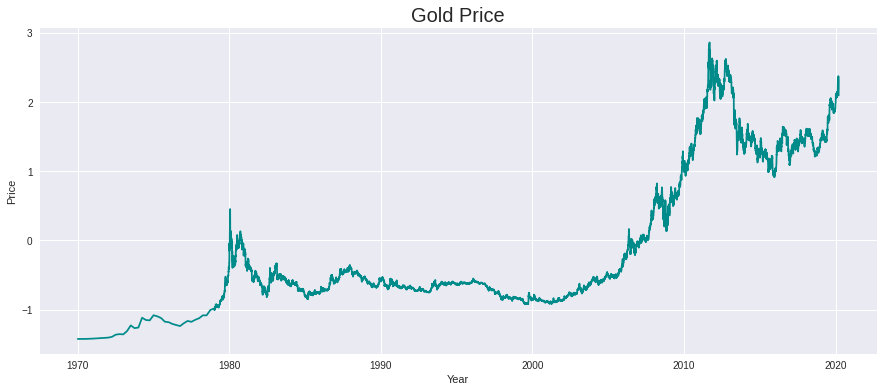

In [11]:
date_data = df['Date'].values
price_data = df['Value'].values

plt.style.use('seaborn')
plt.figure(figsize=(15, 6))
plt.plot(date_data,price_data,color= 'darkcyan')
plt.xlabel("Year"); 
plt.ylabel("Price (US $ per ounce)");
plt.title('Gold Price',
          fontsize=20);
plt.show()

<h1> <strong> 6. Membagi dataset menjadi 80% data train dan 20% data test</strong></h1>

In [12]:
from sklearn.model_selection import train_test_split
price_train, price_test, date_train, date_test = train_test_split(price_data, date_data, test_size=0.2, random_state=0,shuffle=False)

In [31]:
len(date_train)

8629

<h1> <strong> 7. Definisi fungsi <code>windowed_dataset</code> untuk mengelompokkan data time series</strong></h1>

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

<h1> <strong> 8. Mengelompokkan data dan membuat model Sequensial</strong></h1>

In [14]:
train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=100)
val_set = windowed_dataset(price_test, window_size=60, batch_size=100, shuffle_buffer=100)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

<h1> <strong> 9. Mendefinisikan <code>Callbacks</code>: <code>EarlyStopping</code> dan <code>ModelCheckPoint</code></strong></h1>

In [18]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_mae', mode = 'min', verbose = 1, patience = 20)
mc = ModelCheckpoint('./model.h5', monitor = 'val_mae', mode = 'min', verbose = 1, save_best_only = True)


<h1> <strong> 10. Proses training model</strong></h1>
<h6>

```
Target MAE <10%  atau <0.4285378
```

</h6>

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=100,
                    validation_data = val_set,
                    verbose =2,
                    callbacks=[es,mc])

Epoch 1/100
86/86 - 64s - loss: 0.1624 - mae: 0.4278 - val_loss: 0.9404 - val_mae: 1.4402

Epoch 00001: val_mae improved from inf to 1.44024, saving model to ./model.h5
Epoch 2/100
86/86 - 52s - loss: 0.0486 - mae: 0.2061 - val_loss: 0.2969 - val_mae: 0.7163

Epoch 00002: val_mae improved from 1.44024 to 0.71634, saving model to ./model.h5
Epoch 3/100
86/86 - 52s - loss: 0.0190 - mae: 0.1231 - val_loss: 0.0730 - val_mae: 0.2726

Epoch 00003: val_mae improved from 0.71634 to 0.27259, saving model to ./model.h5
Epoch 4/100
86/86 - 52s - loss: 0.0160 - mae: 0.1201 - val_loss: 0.0481 - val_mae: 0.2047

Epoch 00004: val_mae improved from 0.27259 to 0.20465, saving model to ./model.h5
Epoch 5/100
86/86 - 52s - loss: 0.0133 - mae: 0.1140 - val_loss: 0.0333 - val_mae: 0.1618

Epoch 00005: val_mae improved from 0.20465 to 0.16182, saving model to ./model.h5
Epoch 6/100
86/86 - 52s - loss: 0.0117 - mae: 0.1078 - val_loss: 0.0263 - val_mae: 0.1449

Epoch 00006: val_mae improved from 0.16182 to 0.

<h1> <strong> 11. Grafik Loss dan MAE dari data Training dan Test</strong></h1>

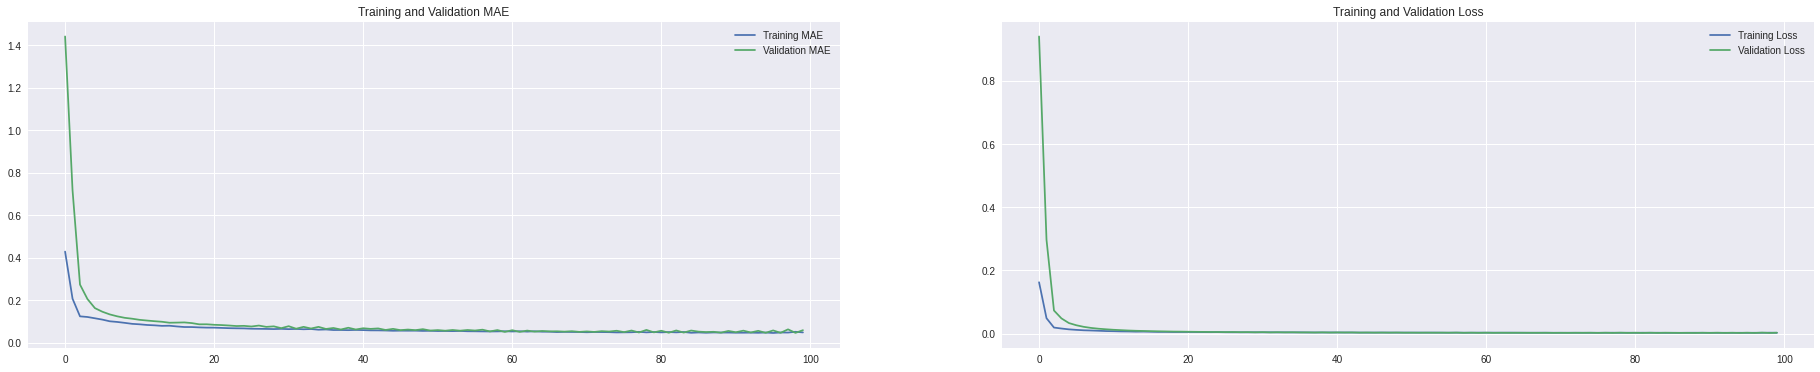

In [29]:
train_loss = history.history['loss']
train_mae = history.history['mae']

val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

epochs_range = range(20)

plt.figure(figsize=(32, 6))
plt.subplot(1, 2,1)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1> <strong> 12. Grafik Harga Emas(Price) Test/Validation VS Prediksi Model yang telah dibuat </strong></h1>

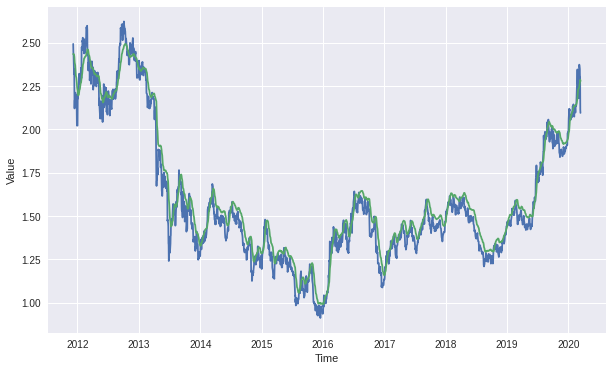

In [40]:
def model_forecast(model, series, window_size):
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size))
 ds = ds.batch(32).prefetch(1)
 forecast = model.predict(ds)
 return forecast

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

window_size=60

rnn_forecast = model_forecast(model, price_data[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[len(price_train)-window_size:-1, 0]
plt.figure(figsize=(10, 6))
plot_series(date_test, price_test)
plot_series(date_test, rnn_forecast)